In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls drive/MyDrive/2040_project_checkpoints/

March20-Resnet-checkpoint-01-0.90.hdf5	RESNET_checkpoint-01-1.56.hdf5
March20-Resnet-checkpoint-01-7.66.hdf5	RESNET_checkpoint-04-1.08.hdf5
March20-Resnet-checkpoint-02-1.40.hdf5	RESNET_checkpoint-05-1.03.hdf5


In [3]:
!mkdir .kaggle

In [4]:
import json
token = {"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [5]:
!mkdir ~/.kaggle
!echo '{"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json && pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!rm -r cassava-leaf-disease-classification
!mkdir cassava-leaf-disease-classification
!kaggle competitions download -c cassava-leaf-disease-classification -p cassava-leaf-disease-classification

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=7efc3152b0ef70c8704c41275b20d61de832438d04f1adea0aa8930a9e0ef81c
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
rm: cannot remove 'cassava-leaf-disease-classification': No such file or directory
100% 5.76G/5.76G [02:16<00:00, 45.9MB/s]
100% 5.76G/5.76G [02:16<00:00, 45.2MB/s]


In [6]:
from zipfile import ZipFile
file_name = '/content/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip'

with ZipFile(file_name, 'r') as zip:

  print("Extracting new files")
  zip.extractall()
  print("done!")

Extracting new files
done!


In [7]:
import tensorflow as tf
import os
from functools import partial
!pip install -q wandb
import wandb
from matplotlib import pyplot as plt
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, InputLayer, 
    Conv2D, MaxPooling2D, ZeroPadding2D, LeakyReLU, Dropout, BatchNormalization
    )

from keras.layers.experimental.preprocessing import (
    RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast
    )

from tensorflow.keras.optimizers import Adam
!pip install tensorflow_addons
from tensorflow_addons.optimizers import MultiOptimizer
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
    )

     |████████████████████████████████| 2.0MB 5.5MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 133kB 27.4MB/s 
     |████████████████████████████████| 163kB 18.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 706kB 3.5MB/s 


## Parameters, Logging Initiation

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SEED = 42
BATCH_SIZE = 16 
# IMAGE_SIZE = [336, 336]
CROP_FACTOR = 0.7
IMAGE_SIZE = [int((520*CROP_FACTOR)-4)] * 2
EPOCHS = 100
BASE_LR = 0.00001 #(1e-5)
HEAD_LR = 0.001 #(1e-3)
LR = 0.001
CLASSES = 5
TRAIN_SPLIT = 0.8

# Learning Rate
BASE_LR_INIT = 0.00001
HEAD_LR_INIT = 0.001
RAMPUP = 10
EXP_DECAY = 0.1

# Early Stopping
MIN_DELTA_ES = 0.001
PATIENCE_ES = 15

# Reduce LR on Plateau
FACTOR_RLR = 0.8
PATIENCE_RLR = 3
MIN_DELTA_RLR = 0.0001
MIN_LR = 0.0000001

RECORD_PATH = tf.io.gfile.glob("train_tfrecords/*.tfrec")
SAVE_PATH = '/content/drive/MyDrive/2040_project_checkpoints/'
SAVE_NAME = "March20-Resnet-checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5" 
# NAME_BASE = "March20-Resnet-checkpoint-"

wandb.init(project="ResNet50")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)

    image = tf.image.central_crop(image, CROP_FACTOR)

    image = image / 255.0 # recale by 255 for inputs between 0 and 1

    return image

In [10]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        label = tf.one_hot(label, 5)
        return image, label
    return image

In [11]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [12]:
data_augmentation = Sequential([
    # RandomCrop(height=100, width=100),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(15),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    # RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
    RandomContrast(factor=0.2)
])

## Shuffling, Splitting, Batching, Augmenting train set, Caching val set, Prefetching

splitting from: https://stackoverflow.com/questions/60704335/how-to-create-train-test-validation-split-of-tf-data-dataset-in-tf-2-1-0

shuffling, batchingm caching, prefetching from https://www.kaggle.com/tt195361/splitting-tensorflow-dataset-for-validation

In [13]:
def get_datasets(filenames, labeled=True, train_split=TRAIN_SPLIT):

    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048, seed=SHUFFLE_SEED)

    # First, split our train dataset into train and validation

    # Size of dataset
    n = sum(1 for _ in dataset)
    n_train = int(n * train_split)
    n_valid = n - n_train

    train_dataset = dataset.take(n_train)
    val_dataset = dataset.skip(n_train).take(n_valid)

    train_dataset = train_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)

    # Augment the training set
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y), 
                  num_parallel_calls=AUTOTUNE)
    
    # From Docs: "The first time the dataset is iterated over, its elements 
    # will be cached either in the specified file or in memory. Subsequent 
    # iterations will use the cached data."
    val_dataset = val_dataset.cache()
    
    # prefetch "allows later elements to be prepared while the current 
    # element is being processed"
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset

In [14]:
train_dataset, val_dataset = get_datasets(RECORD_PATH)

## (Optional) Inspect Records

In [15]:
# image_batch, label_batch = next(iter(dataset_original))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10, 10))
#     for n in range(25):
#         ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n] / 255.0)
#         plt.title(f"{label_batch[n]}")
#         plt.axis("off")

# show_batch(image_batch.numpy(), label_batch.numpy())

# for raw_record in dataset_original.take(1):
    # example = tf.train.Example()
    # example.ParseFromString(raw_record)
    # print(example)

## Sequential Model

In [16]:
# Re-loads the MobileNet model without the top or FC layers
# tf.keras.backend.clear_session()

resnet_base = ResNet50(include_top=False, 
                        weights='imagenet', 
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                        classes=CLASSES,
                        classifier_activation=None)
    
model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),              

    resnet_base,
    GlobalAveragePooling2D(),

    # Dense(1024, kernel_regularizer='l2'),
    # BatchNormalization(),
    # LeakyReLU(),
    # Dropout(0.5),

    Dropout(0.5),
    Dense(512, kernel_regularizer='l2', activation='relu'),
    BatchNormalization(),
    
    # Dropout(0.5),
    # Dense(128, kernel_regularizer='l2', activation='relu'),
    # BatchNormalization(),
    
    # Dropout(0.5),
    # Dense(32, kernel_regularizer='l2', activation='relu'),
    # BatchNormalization(),

    Dense(CLASSES,activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
checkpoint = ModelCheckpoint(SAVE_PATH+SAVE_NAME,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             save_weights_only = False,
                             verbose = 1)

# CUSTOM CALLBACK TO SAVE CHECKPOINT WITHOUT OPTIMIZER

# class CheckpointNoOpt(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         model.save(filepath=SAVE_PATH+NAME_BASE+f"final_version-{epoch}-.hdf5",
#                    overwrite=False,
#                    include_optimizer=False)
#         # print("End epoch {} of training; got log keys: {}".format(epoch, keys))
# checkpoint = CheckpointNoOpt()

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = MIN_DELTA_ES, 
                          patience = PATIENCE_ES,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = FACTOR_RLR,
                              patience = PATIENCE_RLR,
                              verbose = 1,
                              min_delta = MIN_DELTA_RLR,
                              min_lr = MIN_LR)

# def lr(epoch, start_lr, rampup_epochs, exp_decay):
#     if epoch < rampup_epochs:
#         return start_lr
#     else:
#         return start_lr * math.exp(-exp_decay * epoch)

# def schedule_base(epoch):
#     return lr(epoch, BASE_LR_INIT, RAMPUP, EXP_DECAY)

# def schedule_head(epoch): 
#     return lr(epoch, HEAD_LR_INIT, RAMPUP, EXP_DECAY)

# scheduler_base = LearningRateScheduler(schedule_base, verbose=0)
# scheduler_head = LearningRateScheduler(schedule_head, verbose=0) 

# learning_rate_base = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=BASE_LR_INIT, decay_steps=20, decay_rate=.1)
# learning_rate_head = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=HEAD_LR_INIT, decay_steps=20, decay_rate=.1)

# var_list_base = model.layers[0]
# var_list_head = model.layers[1:]
# opt_base = Adam(learning_rate=learning_rate_base)
# opt_head = Adam(learning_rate=learning_rate_head)

# optimizers_and_layers = [(opt_base, var_list_base),(opt_head, var_list_head)]
# opt = MultiOptimizer(optimizers_and_layers)


# train_opt_base = opt_base.apply_gradients(zip(grads_base, var_list_base))
# train_opt_head = opt_head.apply_gradients(zip(grads_head, var_list_head))
# train_opt = tf.group(train_opt_base, train_opt_head)

callbacks = [checkpoint, earlystop, reduce_lr, wandb.keras.WandbCallback()]

model.compile(loss = 'categorical_crossentropy',
            #   optimizer = opt,
              optimizer = Adam(learning_rate=LR),
              metrics = ['accuracy'])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 12, 12, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,641,413
Trainable params: 24,587,269
Non-trainable params: 54,144
_____________________________________

In [18]:
history = model.fit(
    train_dataset,
    # class_weight = class_weights,
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1#,
    #batch_size=BATCH_SIZE#,
    #steps_per_epoch = STEPS_PER_EPOCH,
    #validation_steps = VALIDATION_STEPS
)

Epoch 1/100
1070/1070 [==============================] - 359s 311ms/step - loss: 4.2777 - accuracy: 0.5735 - val_loss: 5.5054 - val_accuracy: 0.1465

Epoch 00001: val_loss improved from inf to 5.50538, saving model to /content/drive/MyDrive/2040_project_checkpoints/March20-Resnet-checkpoint-01-5.51.hdf5
Epoch 2/100
1070/1070 [==============================] - 298s 274ms/step - loss: 1.3615 - accuracy: 0.6027 - val_loss: 1.4886 - val_accuracy: 0.6236

Epoch 00002: val_loss improved from 5.50538 to 1.48865, saving model to /content/drive/MyDrive/2040_project_checkpoints/March20-Resnet-checkpoint-02-1.49.hdf5
Epoch 3/100
1070/1070 [==============================] - 293s 269ms/step - loss: 1.2209 - accuracy: 0.6174 - val_loss: 2.0164 - val_accuracy: 0.6079

Epoch 00003: val_loss did not improve from 1.48865
Epoch 4/100
1070/1070 [==============================] - 290s 267ms/step - loss: 1.2139 - accuracy: 0.6140 - val_loss: 1.2005 - val_accuracy: 0.6259

Epoch 00004: val_loss improved from

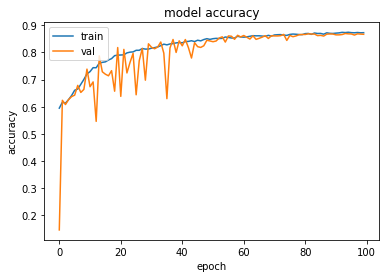

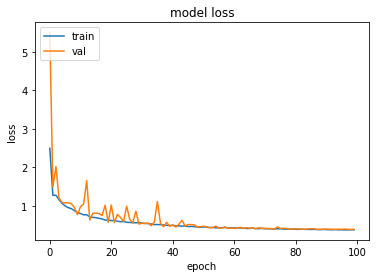

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
wandb.finish()

epoch,99
loss,0.37787
accuracy,0.87247
val_loss,0.39083
val_accuracy,0.86659
lr,2e-05
_runtime,30937
_timestamp,1616358434
_step,99
best_val_loss,0.3872
best_epoch,98


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▃▂▂▂▃▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▅▇▇▆▇▆▇██▆▇█▇██████████████████████
lr,██████▇▅▅▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [21]:
model.evaluate(val_dataset)

268/268 [==============================] - 20s 75ms/step - loss: 0.3908 - accuracy: 0.8666


[0.3908272385597229, 0.8665887713432312]

In [22]:
import numpy as np

np_val_dataset = list(val_dataset.as_numpy_iterator())

In [23]:
len(np_val_dataset)

print(type(np_val_dataset[0][1]))

<class 'numpy.ndarray'>


In [24]:


for x_batch in np_val_dataset[0]:

  # print(type(x_batch))
  # print(type(y_batch))

  print(x_batch.shape)
  # print(y_batch.shape)


(16, 360, 360, 3)
(16, 5)
